In [7]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.supervised.train_fraud_supervised import FraudModelConfig, train_fraud_model
from uais.utils.metrics import compute_classification_metrics, compute_confusion_matrix
from uais.utils.plotting import plot_roc_curve, plot_pr_curve


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [8]:
feats_path = project_root / 'data' / 'processed' / 'fraud' / 'fraud_features.parquet'
df_feats = pd.read_parquet(feats_path)

print('Loaded features:', df_feats.shape)
df_feats.head()


Loaded features: (284807, 35)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,amount_log,time_hours,time_seconds_mod_day,hour_of_day
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.014760,0.000000,0.0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,1.305626,0.000000,0.0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.939276,0.000278,1.0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.824306,0.000278,1.0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.262539,0.000556,2.0,0


In [9]:
target_col = 'Class'
X = df_feats.drop(columns=[target_col])
y = df_feats[target_col].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)
print('Train fraud ratio:', y_train.mean())
print('Val fraud ratio:', y_val.mean())
print('Test fraud ratio:', y_test.mean())


Train: (170884, 34) Val: (56961, 34) Test: (56962, 34)
Train fraud ratio: 0.0017263172678542169
Val fraud ratio: 0.0017204754130018785
Test fraud ratio: 0.0017380007724447878


In [10]:
config = FraudModelConfig(
    model_type='hist_gb',
    max_depth=4,
    learning_rate=0.1,
    max_iter=200,
)

model, val_metrics = train_fraud_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    config=config,
)

print('Validation metrics (supervised):')
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")


Validation metrics (supervised):
roc_auc: 0.8916
pr_auc: 0.5226
f1: 0.6636
precision: 0.5984
recall: 0.7449
accuracy: 0.9987


In [11]:
if hasattr(model, 'predict_proba'):
    y_test_prob = model.predict_proba(X_test)[:, 1]
else:
    scores = model.decision_function(X_test)
    y_test_prob = 1.0 / (1.0 + np.exp(-scores))

test_metrics = compute_classification_metrics(y_test.values, y_test_prob, threshold=0.5)
print('Test metrics (supervised):')
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

y_test_pred = (y_test_prob >= 0.5).astype(int)
cm = compute_confusion_matrix(y_test.values, y_test_pred)
print('Confusion matrix [[tn, fp], [fn, tp]]:', cm)


Test metrics (supervised):
roc_auc: 0.8920
pr_auc: 0.5918
f1: 0.7080
precision: 0.6299
recall: 0.8081
accuracy: 0.9988
Confusion matrix [[tn, fp], [fn, tp]]: [[56816    47]
 [   19    80]]


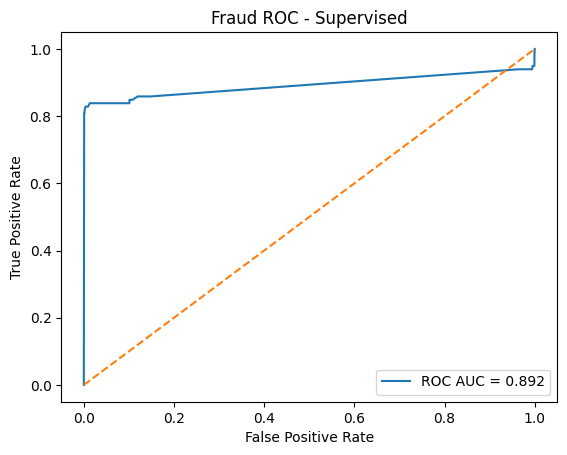

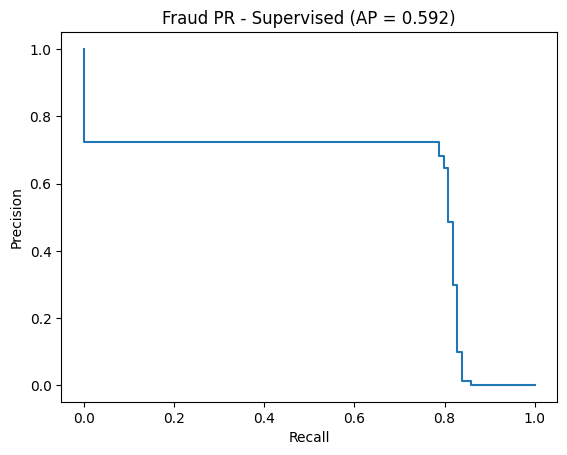

In [12]:
plot_roc_curve(y_test.values, y_test_prob, title='Fraud ROC - Supervised')
plot_pr_curve(y_test.values, y_test_prob, title='Fraud PR - Supervised')
